# Multiplicative Gaussian Noise

This example shows how PINTS handles multiplicative Gaussian noise. In a multiplicative Gaussian noise process, the variance of the noise term scales with the magnitude of the output:

$$X(t) = f(t;\theta) + f(t;\theta)^\eta  \epsilon(t)$$

where

$$\epsilon(t) \sim N(0, \sigma) \text{ iid}$$

Therefore, portions of the time-series with greater magnitude will also see a higher standard deviation of the error terms.

In the first example, we generate data according to this noise model, and use optimisation to infer the parameters.

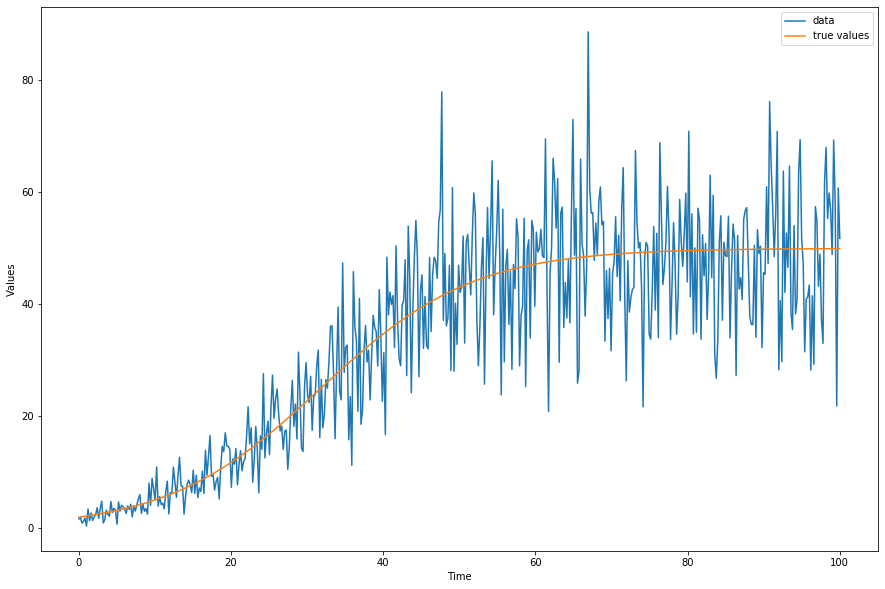

In [2]:
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt
import pints.noise

# Use the toy logistic model
model = toy.LogisticModel()

# Set some parameters
real_parameters = [0.1, 50]

# Create fake data
times = model.suggested_times()
times = np.linspace(0, 100, 500)
values = model.simulate(real_parameters, times)

# Add noise according to multiplicative Gaussian
noisy_values = values + pints.noise.multiplicative_gaussian(0.8, 0.5, values)

# Create an inference problem
problem = pints.SingleOutputProblem(model, times, noisy_values)

# Show the generated data
plt.figure(figsize=(15,10))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, noisy_values, label='data')
plt.plot(times, values, label='true values')
plt.legend()
plt.show()

In this case, the way the noise magnitude increases with the magnitude of the function is visible in the plot of the data above. However, if it were not so clear, we might make the incorrect assumption of independent Gaussian noise. In the code below, we estimate the parameters under this incorrect assumption.

In [3]:
# Make a log likelihood assuming independent Gaussian noise
log_likelihood = pints.GaussianLogLikelihood(problem)

# Set up the optimisation problem
y0 = np.array([.1, 10, 1])
boundaries = pints.RectangularBoundaries([0, 5, 1e-3], [1, 500, 10])
opt = pints.OptimisationController(log_likelihood,
                                   y0,
                                   boundaries=boundaries,
                                   method=pints.XNES)

# Run the optimisation
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

Maximising LogPDF
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Time m:s
0     7     -23830.37   0:00.0
1     14    -18960.43   0:00.0
2     21    -18855.47   0:00.0
3     28    -12989.69   0:00.0
20    147   -1819.028   0:00.0
40    287   -1815.404   0:00.0
60    427   -1815.404   0:00.0
80    567   -1814.145   0:00.1
100   707   -1814.142   0:00.1
120   847   -1814.141   0:00.1
140   987   -1814.141   0:00.1
160   1127  -1814.141   0:00.1
180   1267  -1814.141   0:00.1
200   1407  -1814.141   0:00.1
220   1547  -1814.141   0:00.1
240   1687  -1814.141   0:00.2
260   1827  -1814.141   0:00.2
280   1967  -1814.141   0:00.2
300   2107  -1814.141   0:00.2
320   2247  -1814.141   0:00.2
340   2387  -1814.141   0:00.2
360   2527  -1814.141   0:00.2
379   2653  -1814.141   0:00.2
Halting: No significant change for 200 iterations.
Estimated parameters:
[ 0.1035083  48.83998912  9.10974039]


After performing the fit based on the incorrect assumption of iid Gaussian noise, it is useful to look at a diagnostic plot of residuals vs. function magnitude. This is possible using the `plot_residuals_vs_output` function in `pints.residuals_diagnostics`.

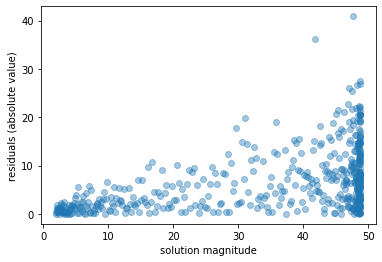

In [4]:
import pints.residuals_diagnostics

fig = pints.residuals_diagnostics.plot_residuals_vs_output(
    np.array([[y1[0], y1[1]]]),
    problem)

plt.show()

This plot shows higher magnitudes in the residuals as the function output increases, suggesting that multiplicative Gaussian noise may be applicable. 

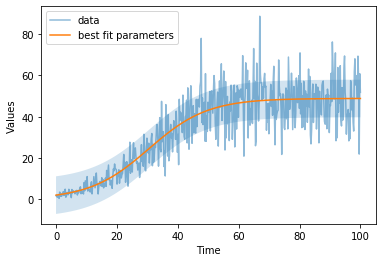

In [5]:
# Show the generated data
simulated_values = problem.evaluate(y1[:2])

# Get the standard deviation (which is constant in this noise model)
sigma = y1[2]

plt.figure()
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, noisy_values, label='data', alpha=0.5)
plt.fill_between(times,
                 simulated_values - sigma,
                 simulated_values + sigma,
                 alpha=0.2)
plt.plot(times, simulated_values, label='best fit parameters')
plt.legend()
plt.show()

Similarly, this plot of the data and the fit also highlights the inaccuracy of the independent Gaussian assumption. Although the best fit model parameters are plausible, the measurement noise variance is being overestimated at small function values and underestimated at large function values.

The next step is to use the correct likelihood , which is available as `pints.MultiplicativeGaussianLogLikelihood`.

In [6]:
# Make a log likelihood assuming the correct multiplicative noise
log_likelihood = pints.MultiplicativeGaussianLogLikelihood(problem)

# Set up the optimisation
y0 = np.array([.1, 10, 0.25, .1])
boundaries = pints.RectangularBoundaries([0, 5, 1e-3, 1e-3], [1, 500, 10, 10])
opt = pints.OptimisationController(log_likelihood,
                                   y0,
                                   boundaries=boundaries,
                                   method=pints.XNES)


# Run the optimisation
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

Maximising LogPDF
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 8
Iter. Eval. Best      Time m:s
0     8     -2111.894   0:00.0
1     16    -2111.894   0:00.0
2     24    -2111.894   0:00.0
3     32    -2111.894   0:00.0
20    168   -1825.282   0:00.0
40    328   -1825.282   0:00.1
60    488   -1823.85    0:00.1
80    648   -1772.201   0:00.1
100   808   -1772.201   0:00.1
120   968   -1772.201   0:00.1
140   1128  -1750.26    0:00.2
160   1288  -1725.302   0:00.2
180   1448  -1699.208   0:00.2
200   1608  -1686.864   0:00.2
220   1768  -1679.461   0:00.2
240   1928  -1674.785   0:00.2
260   2088  -1672.335   0:00.3
280   2248  -1671.097   0:00.3
300   2408  -1670.761   0:00.3
320   2568  -1670.689   0:00.3
340   2728  -1670.68    0:00.3
360   2888  -1670.677   0:00.4
380   3048  -1670.677   0:00.4
400   3208  -1670.677   0:00.4
420   3368  -1670.677   0:00.4
440   3528  -1670.677   0:00.5
460   3688  -1670.677   0:00.5
480   3848  -16

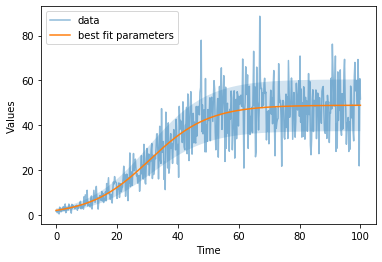

In [7]:
# Show the generated data
simulated_values = problem.evaluate(y1[:2])

# Get the inferred noise model parameters
eta = y1[2]
sigma = y1[3]

plt.figure()
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, noisy_values, alpha=0.5, label='data')
plt.fill_between(times, simulated_values - sigma*simulated_values**eta, simulated_values + sigma*simulated_values**eta, alpha=0.2)
plt.plot(times, simulated_values, label='best fit parameters')#
plt.legend()
plt.show()

With the correct noise model, we can see that the standard deviation of the measurement process scales appropriately with the magnitude of the trajectory.